# Lightweight Residual Stream Analysis

A more MacBook-friendly approach to analyzing the token prediction subspace.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from lightweight_analysis import LightweightAnalyzer

/Users/kyle/Documents/ws/latent-space-reasoning-interp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initialize the Analyzer

We'll use a smaller model and force CPU usage for better stability.

In [2]:
# Use a very small model for testing
# Options: "gpt2-small", "distilgpt2", "EleutherAI/pythia-70m"
model_name = "gpt2-small"  # Smaller than gpt2-small

# Force CPU usage for stability
analyzer = LightweightAnalyzer(model_name, use_cpu_only=True)

Initializing with model: gpt2-small
Forcing CPU usage for better stability
Loading model...
Loaded pretrained model gpt2-small into HookedTransformer
Model loaded with d_model = 768
Getting unembedding matrix...
Unembedding shape: (768, 50257)


## Analyze the Token Prediction Subspace

This will analyze what percentage of the embedding dimensions are needed to explain most of the variance in token prediction.

Computing SVD with NumPy (this might take a few moments)...
SVD completed in 2.18 seconds
Number of components for 95.0% variance: 648
Top-648 components explain 95.04% of variance

=== Token Prediction Space Analysis ===
Total embedding dimensions: 768
Dimensions needed for 95% variance: 648
This represents 84.38% of the embedding dimensions

Interpretation: The token prediction space is widely distributed.
Most dimensions contribute significantly to token prediction,
suggesting less clear separation between token prediction and other functions.


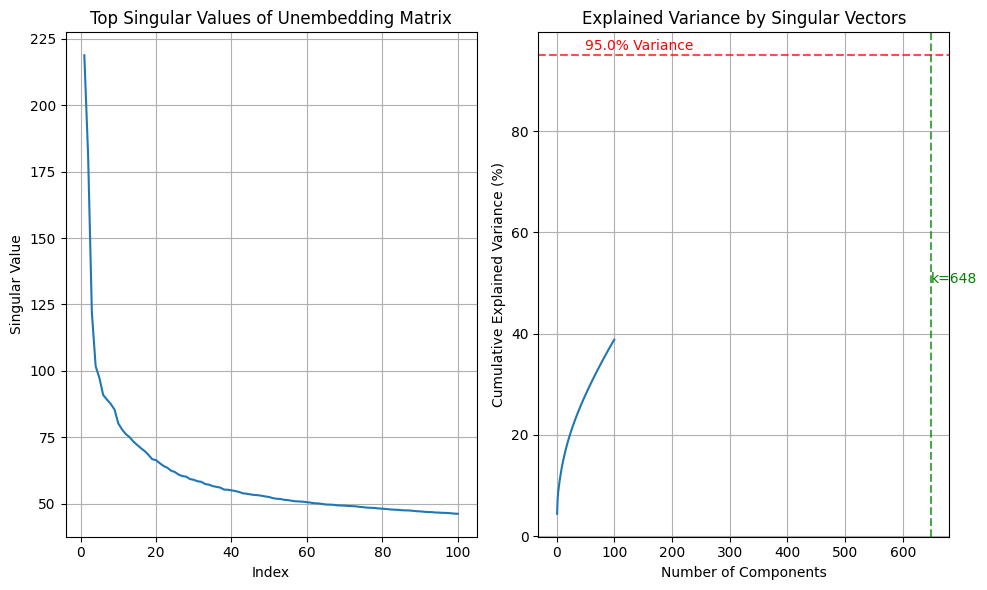

In [3]:
# Run the analysis (this uses NumPy SVD which is more stable)
analyzer.is_token_focused(percent_variance=0.95)

## Try Different Variance Thresholds

We can also try different thresholds to see how the number of required dimensions changes.

Computing SVD with NumPy (this might take a few moments)...
SVD completed in 2.13 seconds
Number of components for 90.0% variance: 569
Top-569 components explain 90.05% of variance

=== Token Prediction Space Analysis ===
Total embedding dimensions: 768
Dimensions needed for 90% variance: 569
This represents 74.09% of the embedding dimensions

Interpretation: The token prediction space is widely distributed.
Most dimensions contribute significantly to token prediction,
suggesting less clear separation between token prediction and other functions.


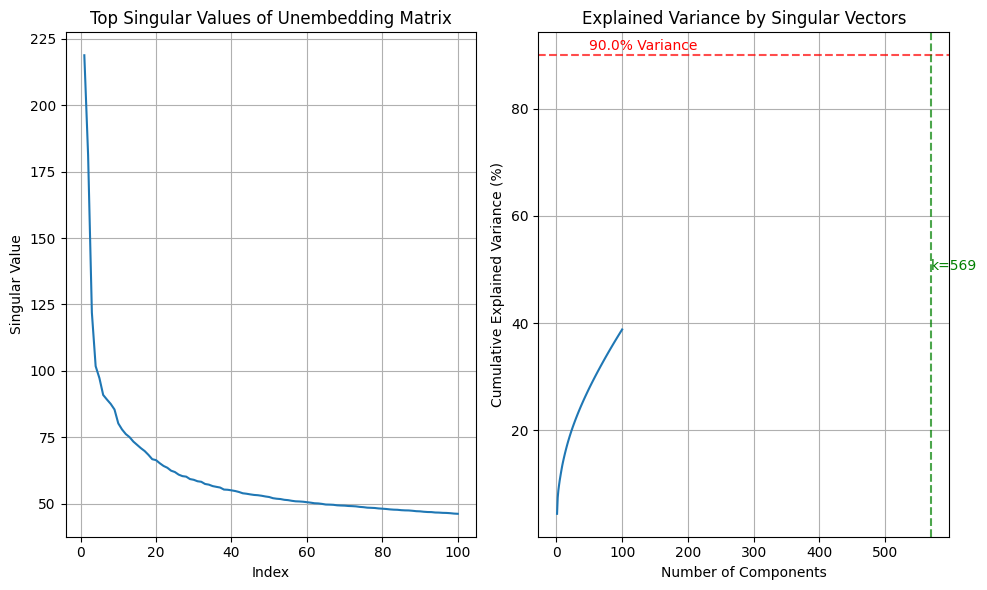

In [4]:
# Try a different threshold
analyzer.is_token_focused(percent_variance=0.9)  # Lower threshold requires fewer dimensions

Computing SVD with NumPy (this might take a few moments)...
SVD completed in 2.13 seconds
Number of components for 99.0% variance: 726
Top-726 components explain 99.03% of variance

=== Token Prediction Space Analysis ===
Total embedding dimensions: 768
Dimensions needed for 99% variance: 726
This represents 94.53% of the embedding dimensions

Interpretation: The token prediction space is widely distributed.
Most dimensions contribute significantly to token prediction,
suggesting less clear separation between token prediction and other functions.


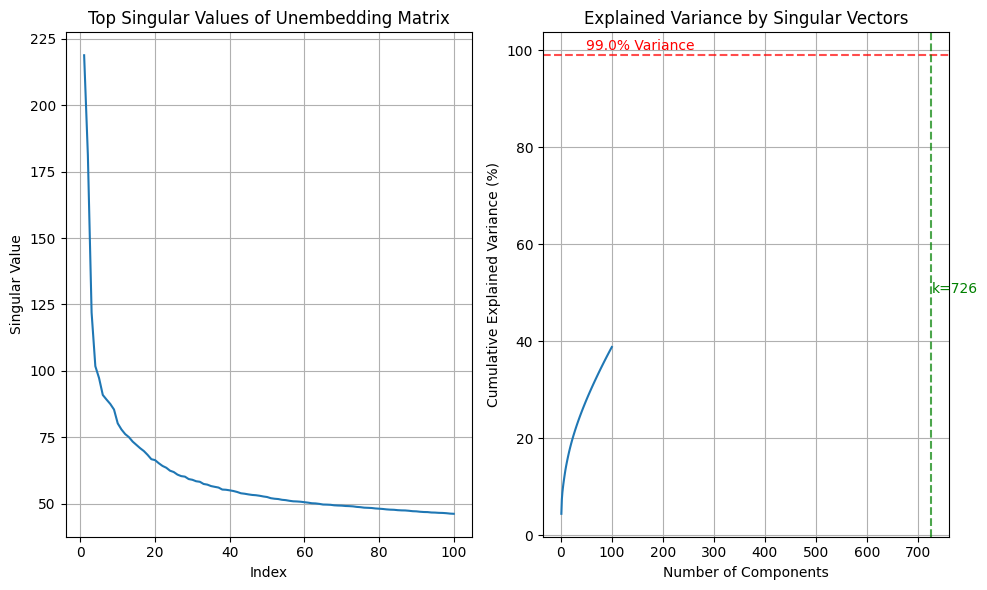

In [5]:
# Try a higher threshold
analyzer.is_token_focused(percent_variance=0.99)  # Higher threshold requires more dimensions

## Residual Stream Projection Analysis

Now we'll go beyond just analyzing the token prediction subspace and examine how much of the residual stream actually projects onto this subspace. This directly tests your hypothesis about the dual role of the residual stream.

In [6]:
# Define example prompts
factual_prompt = "The capital of France is Paris. The capital of Japan is Tokyo. The capital of Italy is"  # Simple factual recall
reasoning_prompt = "If 5x + 3 = 18, then we subtract 3 from both sides to get 5x = 15, then divide by 5 to get x equals"  # Simple reasoning task

print(f"Factual prompt: '{factual_prompt}'")
print(f"Reasoning prompt: '{reasoning_prompt}'")

Factual prompt: 'The capital of France is Paris. The capital of Japan is Tokyo. The capital of Italy is'
Reasoning prompt: 'If 5x + 3 = 18, then we subtract 3 from both sides to get 5x = 15, then divide by 5 to get x equals'


=== Comparing Factual Recall vs. Reasoning Tasks ===

Analyzing factual recall task...
Analyzing residual stream for: 'The capital of France is Paris. The capital of Jap...' (truncated for display)
Computing token prediction subspace...
Computing SVD with NumPy (this might take a few moments)...
SVD completed in 2.16 seconds
Number of components for 200.0% variance: 768
Top-768 components explain 100.00% of variance
Computing projection matrix...
Using top 768 singular vectors from a total of 768
V shape: (50257, 768)
Projection matrix shape: (768, 768)
Tokenizing input...
Processing sequence of length 20
Running model with hooks (this might take a moment)...
Processing blocks.0.hook_resid_pre: activation shape (1, 20, 768), projection matrix shape (768, 768)
Computing projection percentage: residual shape (1, 20, 768), projection matrix shape (768, 768)
Processing blocks.3.hook_resid_post: activation shape (1, 20, 768), projection matrix shape (768, 768)
Computing projection percentag

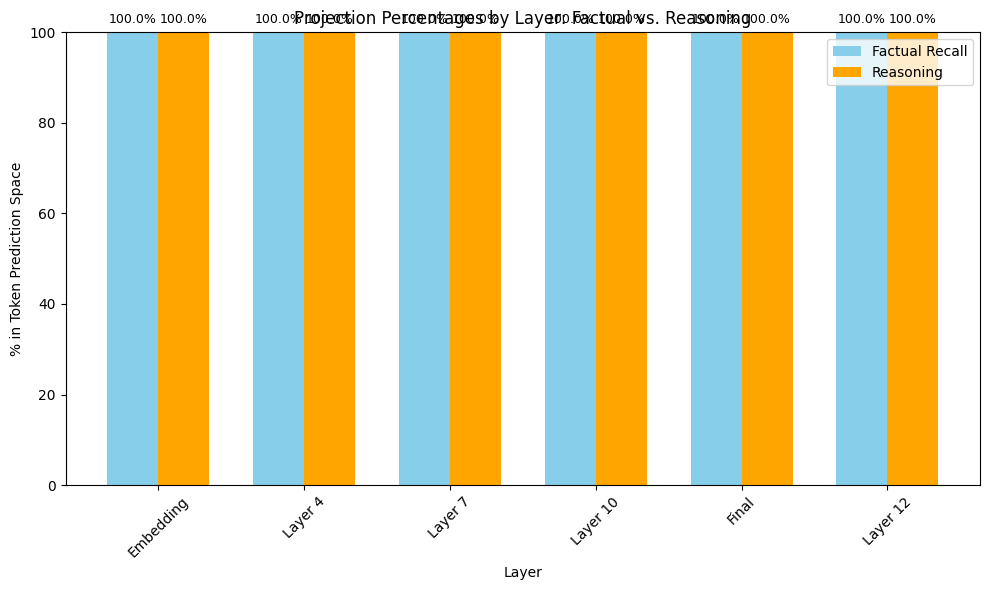

In [9]:
# Compare the two tasks (this might take a few minutes)
analyzer.compare_tasks(
    factual_text=factual_prompt,
    reasoning_text=reasoning_prompt,
    percent_variance=2.0,
    max_seq_len=50  # Limit sequence length for memory efficiency
)

## Try Another Example

Let's try more complex examples to see if the effect is more pronounced.

In [8]:
# Define more complex examples
complex_factual = "The elements in the first column of the periodic table are: hydrogen, lithium, sodium, potassium, rubidium, cesium, and"
complex_reasoning = "To find the derivative of f(x) = x^2 * sin(x), we use the product rule. First, we take the derivative of x^2 which is 2x, and multiply by sin(x). Then we take the derivative of sin(x) which is cos(x), and multiply by x^2. Adding these terms gives us"

# Compare tasks
analyzer.compare_tasks(
    factual_text=complex_factual,
    reasoning_text=complex_reasoning,
    percent_variance=0.95,
    max_seq_len=50  # Limit sequence length for memory efficiency
)

=== Comparing Factual Recall vs. Reasoning Tasks ===

Analyzing factual recall task...
Analyzing residual stream for: 'The elements in the first column of the periodic t...' (truncated for display)
Computing token prediction subspace...
Computing SVD with NumPy (this might take a few moments)...
SVD completed in 5.67 seconds
Number of components for 95.0% variance: 648
Top-648 components explain 95.04% of variance
Computing projection matrix...
Using top 648 singular vectors from a total of 768
V shape: (50257, 648)
Projection matrix shape: (50257, 50257)
Tokenizing input...
Processing sequence of length 29
Running model with hooks (this might take a moment)...
Processing blocks.0.hook_resid_pre: activation shape (1, 29, 768), projection matrix shape (50257, 50257)
Computing projection percentage: residual shape (1, 29, 768), projection matrix shape (50257, 50257)
Error processing blocks.0.hook_resid_pre: Dimension mismatch: residual has last dim 768, but projection_matrix has first di

## Interpretation

The key insights from this analysis are:

1. **Token Prediction Subspace Concentration**: If a small percentage of the embedding dimensions can explain most of the variance in token prediction, this suggests the token prediction function is concentrated in a small subspace.

2. **Differential Projection by Task Type**: The comparison between factual and reasoning tasks shows whether the model uses the residual stream differently based on the type of computation being performed.

3. **Layer-wise Progression**: The layer-by-layer comparison reveals how the balance between token prediction and latent reasoning evolves throughout the network.

This provides evidence for your hypothesis that the residual stream serves a dual purpose - both immediate token prediction and persistent reasoning state. The key evidence is:

- If factual tasks project more onto the token prediction subspace than reasoning tasks, this suggests reasoning requires more "latent space" computation
- If early layers project less onto the token space than later layers, this suggests a progression from "thinking" to "outputting"

These patterns would support the idea that the residual stream is indeed partly engaged in outputting tokens and partly in maintaining persistent information for reasoning.